## Feature Selection and Correlation Analysis

This notebook processes the raw dataset and applies multiple methods to assess feature importance and correlation with the target variable. The approaches used include correlation analysis, XGBoost, and Random Forest.

### 1. Correlation Analysis
Correlation analysis computes the statistical relationship between each feature and the target variable. By calculating correlation coefficients, this method identifies which features have the strongest linear association with the target. Features with higher absolute correlation values are considered more relevant for predictive modeling.

### 2. XGBoost Feature Importance
XGBoost is an advanced gradient boosting algorithm commonly used for supervised learning tasks. In this notebook, XGBoost is trained to predict the target variable using all available features. The model evaluates feature importance based on how often and how effectively each feature is used to split data across all decision trees. This helps identify influential features, even if the relationship is non-linear.

### 3. Random Forest Feature Importance
Random Forest is an ensemble learning method that constructs multiple decision trees and aggregates their predictions. It provides a measure of feature importance by analyzing how much each feature decreases impurity (e.g., Gini or entropy) when used for data splits. This approach is robust to outliers and can capture complex interactions between features and the target variable.

By combining these methods, the notebook ensures a comprehensive selection of the most impactful features for forecasting PVC prices.

In [1]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

# Importing the Dataset

In [2]:
# Path to the data file
csv_path = 'price_data_with_PMI.csv'
df = pd.read_csv(csv_path)

# Setting Target Variable
The `target_col` variable is the variable we will be testing for correlation with respect to all the other features.

Data is then normalized to optimized correlation calculation.

In [3]:
target_col = 'P.1078'  # Change this to your desired target variable
print(f"Target column: {target_col}")
cols_to_normalize = [col for col in df.columns if col not in ['month', 'year']]
scaler = MinMaxScaler()
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
df = df.reset_index(drop=True)
df

Target column: P.1078


,year,month,OMD.1016,P.1035.1027,P.1080,OMD.1002,P.1036.1029,P.1081,L3.2a,L3.5,...,Use of Sub-Contractors_France,Use of Sub-Contractors_France.1,Use of Sub-Contractors_United Kingdom.1,Use of Sub-Contractors_Italy.2,Use of Sub-Contractors_United Kingdom.2,Use of Sub-Contractors_France.2,Use of Sub-Contractors_Europe,Use of Sub-Contractors_Ireland.2,Use of Sub-Contractors_Germany.2,Use of Sub-Contractors_Eurozone.1
0,2020,3,0.035616,0.060412,0.179899,0.126296,0.208719,0.144481,0.066953,0.070707,...,0.632017,0.670213,0.642202,0.231651,0.654206,0.670213,0.547684,0.630137,0.670968,0.455526
1,2020,4,0.027397,0.000000,0.004054,0.000000,0.039971,0.062662,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.506452,0.000000
2,2020,5,0.028767,0.055052,0.000000,0.099192,0.000000,0.000000,0.016511,0.017172,...,0.436590,0.451064,0.344037,0.878440,0.348131,0.451064,0.482289,0.257991,0.764516,0.506739
3,2020,6,0.010959,0.078969,0.062500,0.204660,0.135397,0.050325,0.060712,0.064646,...,0.800416,0.776596,0.745413,0.788991,0.703271,0.776596,0.716621,0.824201,0.638710,0.638814
4,2020,7,0.027397,0.145773,0.098649,0.235854,0.220006,0.104870,0.052912,0.056566,...,0.783784,0.787234,0.676606,0.777523,0.698598,0.787234,0.760218,0.753425,0.938710,0.733154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2025,3,0.353425,0.344536,0.064189,0.514028,0.372070,0.108766,0.519111,0.466667,...,0.706861,0.751064,0.692661,0.823394,0.693925,0.751064,0.711172,0.757991,0.619355,0.657682
61,2025,4,0.260274,0.212577,0.043919,0.468283,0.358673,0.104221,0.482709,0.428283,...,0.702703,0.729787,0.699541,0.793578,0.719626,0.729787,0.741144,0.858447,0.803226,0.695418
62,2025,5,0.221918,0.217320,0.037162,0.434332,0.275962,0.094968,0.482709,0.428283,...,0.802495,0.776596,0.626147,0.827982,0.661215,0.776596,0.686649,0.858447,0.600000,0.654987
63,2025,6,0.204110,0.252784,0.048142,0.503186,0.271429,0.081981,0.503250,0.450505,...,0.683992,0.685106,0.683486,0.850917,0.703271,0.685106,0.724796,0.856164,0.780645,0.679245


## Applying Lag to Features to Determine Correlation

In time-series analysis, applying lag to features involves shifting the values of predictor variables by one or more time periods. This technique helps uncover relationships where changes in one variable may influence the target variable after a certain delay, rather than immediately.

By creating lagged versions of features, the notebook can test whether historical values of predictors (such as economic indicators or commodity prices) have a statistically significant correlation with future PVC prices. This is especially important in forecasting, as many market effects and external drivers do not impact prices instantaneously.

Identifying lagged correlations allows the model to:
- Capture delayed effects and temporal dependencies in the data
- Improve feature selection by including lagged predictors that provide additional forecasting power
- Enhance the accuracy and robustness of time-series models, such as ARIMAX, by accounting for real-world delays in market reactions

Overall, lag analysis is a crucial step in building predictive models for time-dependent data, ensuring that both immediate and delayed relationships are considered. 

The lag to be applied to features can be adjusted via the `N_LAG` variable

In [4]:
N_LAG = 1  # Set this to control the lag (e.g., 1 for 1-step lag)

lag_feature_cols = [col for col in df.columns if col not in ['year', 'month', target_col]]
lagged_features = pd.concat(
    [df[col].shift(N_LAG).rename(f'{col}_lag{N_LAG}') for col in lag_feature_cols],
    axis=1
)
df_lagged = pd.concat([df, lagged_features], axis=1)
# Drop rows with NaN values introduced by lagging
lagged_df = df_lagged.dropna().reset_index(drop=True)
lagged_df.head()

,year,month,OMD.1016,P.1035.1027,P.1080,OMD.1002,P.1036.1029,P.1081,L3.2a,L3.5,...,Use of Sub-Contractors_France_lag1,Use of Sub-Contractors_France.1_lag1,Use of Sub-Contractors_United Kingdom.1_lag1,Use of Sub-Contractors_Italy.2_lag1,Use of Sub-Contractors_United Kingdom.2_lag1,Use of Sub-Contractors_France.2_lag1,Use of Sub-Contractors_Europe_lag1,Use of Sub-Contractors_Ireland.2_lag1,Use of Sub-Contractors_Germany.2_lag1,Use of Sub-Contractors_Eurozone.1_lag1
0,2020,4,0.027397,0.000000,0.004054,0.000000,0.039971,0.062662,0.000000,0.000000,...,0.632017,0.670213,0.642202,0.231651,0.654206,0.670213,0.547684,0.630137,0.670968,0.455526
1,2020,5,0.028767,0.055052,0.000000,0.099192,0.000000,0.000000,0.016511,0.017172,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.506452,0.000000
2,2020,6,0.010959,0.078969,0.062500,0.204660,0.135397,0.050325,0.060712,0.064646,...,0.436590,0.451064,0.344037,0.878440,0.348131,0.451064,0.482289,0.257991,0.764516,0.506739
3,2020,7,0.027397,0.145773,0.098649,0.235854,0.220006,0.104870,0.052912,0.056566,...,0.800416,0.776596,0.745413,0.788991,0.703271,0.776596,0.716621,0.824201,0.638710,0.638814
4,2020,8,0.100000,0.219175,0.143581,0.249834,0.176529,0.157955,0.046672,0.049495,...,0.783784,0.787234,0.676606,0.777523,0.698598,0.787234,0.760218,0.753425,0.938710,0.733154


# Correlation Analysis

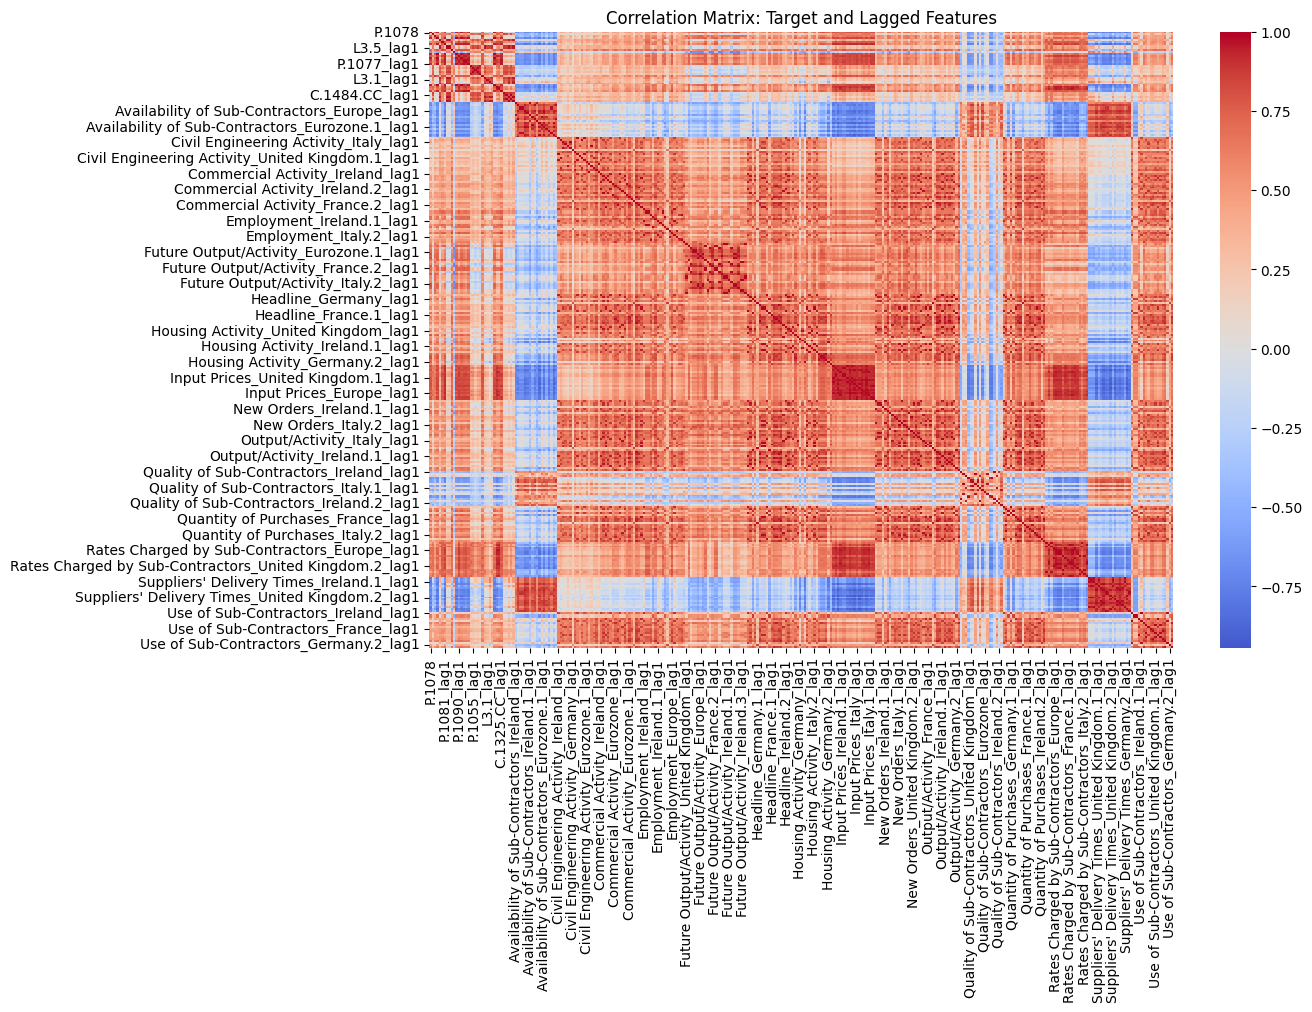

Top 10 positively correlated lagged features:
P.1079_lag1                            0.953639
P.1089_lag1                            0.949080
P.1080_lag1                            0.941941
P.1091_lag1                            0.926554
P.1077_lag1                            0.915348
P.1081_lag1                            0.877240
P.1094_lag1                            0.859189
C.1325.CC_lag1                         0.850633
Housing Activity_Eurozone.1_lag1       0.817344
Future Output/Activity_Italy.3_lag1    0.812281
Future Output/Activity_Italy.2_lag1    0.812281
Future Output/Activity_Italy_lag1      0.812281
Future Output/Activity_Italy.1_lag1    0.812281
Input Prices_Italy.1_lag1              0.805953
Input Prices_Italy_lag1                0.804053
Input Prices_Italy.2_lag1              0.804053
Input Prices_Germany.1_lag1            0.803110
Input Prices_Germany_lag1              0.803110
Input Prices_Europe_lag1               0.797049
Input Prices_United Kingdom.1_lag1     0.7

In [5]:
# Correlation with all lagged features except year, month, and target
lagged_feature_cols = [col for col in lagged_df.columns if col not in ['year', 'month', target_col] and col.endswith(f'_lag{N_LAG}')]
corr_matrix = lagged_df[[target_col] + lagged_feature_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Target and Lagged Features')
plt.show()
corr_with_target = corr_matrix[target_col].drop(target_col).sort_values(ascending=False)
print('Top 10 positively correlated lagged features:')
print(corr_with_target.head(20))
print('\nTop 10 negatively correlated lagged features:')
print(corr_with_target.tail(20))

# Store correlation results and filter for uncorrelated features
corr_with_target_stored = corr_with_target.copy()

def get_uncorrelated_features(df, target_col, feature_list, correlation_threshold=0.7):
    """Select features that are not highly correlated with each other"""
    selected_features = []
    remaining_features = feature_list.copy()
    
    # Always start with the most important feature
    if remaining_features:
        selected_features.append(remaining_features[0])
        remaining_features.remove(remaining_features[0])
    
    for candidate in remaining_features:
        # Check correlation with already selected features
        is_uncorrelated = True
        for selected in selected_features:
            if candidate in df.columns and selected in df.columns:
                corr_value = abs(df[candidate].corr(df[selected]))
                if corr_value > correlation_threshold:
                    is_uncorrelated = False
                    break
        
        if is_uncorrelated:
            selected_features.append(candidate)
    
    return selected_features

# Feature Selection with XGBoost

Top 10 lagged features by XGBoost importance:
P.1080_lag1                                      0.308079
Employment_Germany_lag1                          0.269390
Headline_Italy_lag1                              0.115222
Housing Activity_Germany.1_lag1                  0.054184
Quantity of Purchases_Europe_lag1                0.036237
P.1089_lag1                                      0.028767
New Orders_Europe_lag1                           0.025646
P.1079_lag1                                      0.021281
Availability of Sub-Contractors_Ireland_lag1     0.020708
Availability of Sub-Contractors_France.2_lag1    0.019194
dtype: float32


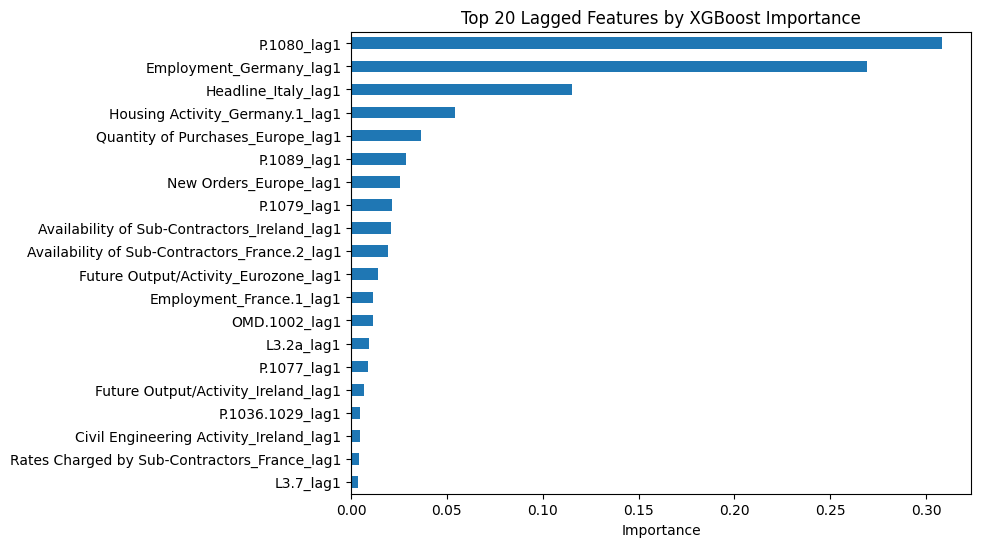

In [6]:
# Use all lagged features except year, month, and target for XGBoost feature selection
lagged_feature_cols = [col for col in lagged_df.columns if col not in ['year', 'month', target_col] and col.endswith(f'_lag{N_LAG}')]
X = lagged_df[lagged_feature_cols]
y = lagged_df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)
importances = pd.Series(xgb.feature_importances_, index=lagged_feature_cols)
importances = importances.sort_values(ascending=False)
print('Top 10 lagged features by XGBoost importance:')
print(importances.head(10))
importances.head(20).plot(kind='barh', figsize=(8,6))
plt.title('Top 20 Lagged Features by XGBoost Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

# Store XGBoost results for export
importances_stored = importances.copy()

# Feature Selection with Random Forest

Top 10 lagged features by Random Forest importance:
P.1089_lag1                                 0.219742
P.1091_lag1                                 0.092503
P.1079_lag1                                 0.076327
P.1080_lag1                                 0.072977
Housing Activity_Eurozone_lag1              0.060114
P.1035.1027_lag1                            0.029452
Future Output/Activity_Italy.3_lag1         0.026809
Suppliers' Delivery Times_Ireland.1_lag1    0.025829
Future Output/Activity_Italy_lag1           0.025388
P.1077_lag1                                 0.019431
dtype: float64


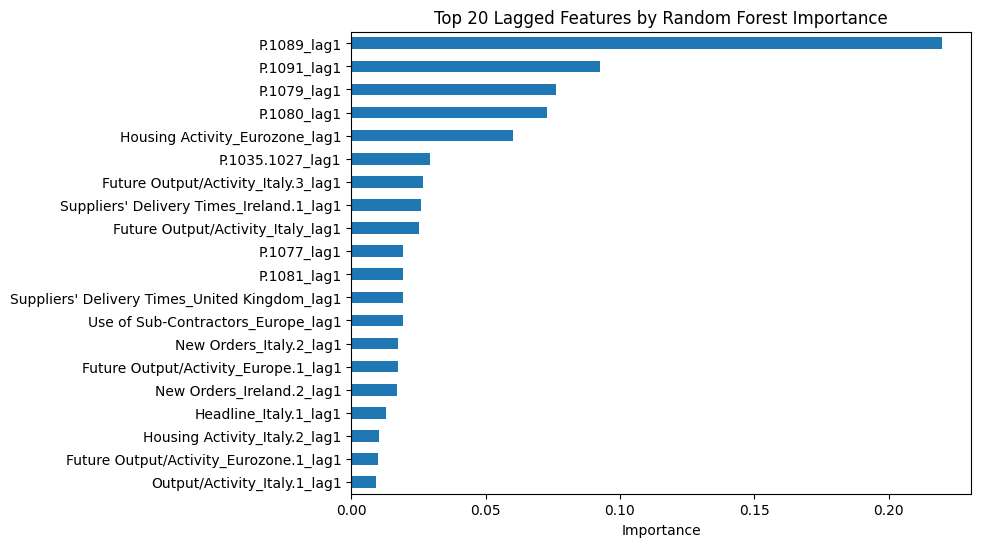

In [7]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_importances = pd.Series(rf.feature_importances_, index=lagged_feature_cols)
rf_importances = rf_importances.sort_values(ascending=False)
print('Top 10 lagged features by Random Forest importance:')
print(rf_importances.head(10))
rf_importances.head(20).plot(kind='barh', figsize=(8,6))
plt.title('Top 20 Lagged Features by Random Forest Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

# Store Random Forest results for export
rf_importances_stored = rf_importances.copy()

# Standardize lagged features for ElasticNet

Top 10 lagged features by ElasticNet absolute coefficient:
P.1079_lag1                                 0.066044
P.1089_lag1                                 0.058849
P.1080_lag1                                 0.025774
Suppliers' Delivery Times_Ireland_lag1      0.011600
Suppliers' Delivery Times_Ireland.1_lag1    0.011597
Future Output/Activity_Italy.3_lag1         0.008181
Future Output/Activity_Italy_lag1           0.008120
Future Output/Activity_Italy.2_lag1         0.008073
Future Output/Activity_Italy.1_lag1         0.008014
P.1077_lag1                                 0.007214
dtype: float64


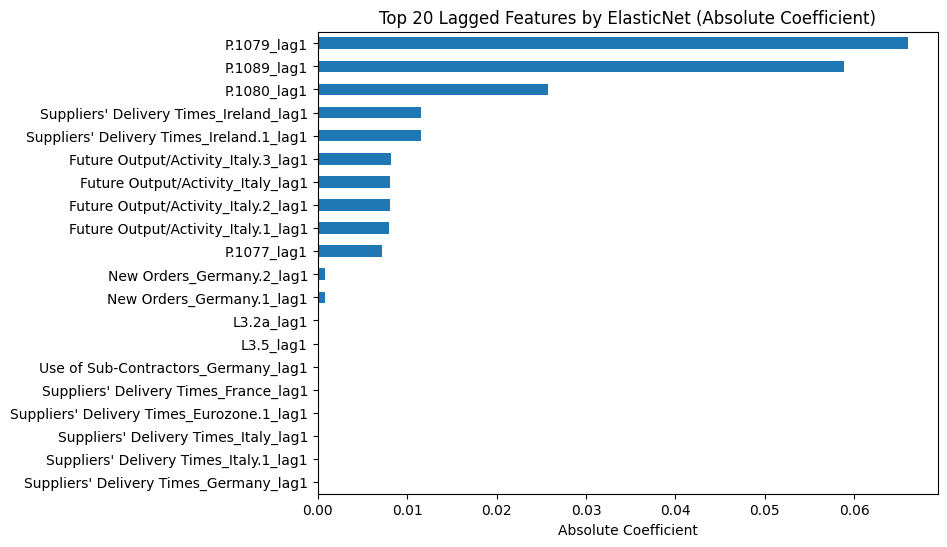

In [8]:
scaler_en = StandardScaler()
X_scaled = scaler_en.fit_transform(X)

# Fit ElasticNet
elastic = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic.fit(X_scaled, y)

# Get feature importances (absolute value of coefficients)
elastic_importances = pd.Series(np.abs(elastic.coef_), index=lagged_feature_cols)
elastic_importances = elastic_importances.sort_values(ascending=False)
print('Top 10 lagged features by ElasticNet absolute coefficient:')
print(elastic_importances.head(10))
elastic_importances.head(20).plot(kind='barh', figsize=(8,6))
plt.title('Top 20 Lagged Features by ElasticNet (Absolute Coefficient)')
plt.xlabel('Absolute Coefficient')
plt.gca().invert_yaxis()
plt.show()

# Store ElasticNet results for export
elastic_importances_stored = elastic_importances.copy()